## Description:

    Ordination using PCoA
    Figure generation for manuscript
    1) Core genotypes over time for paneled figure
    2) R1 - year of release
    3) V6 Fertility
    4) R3 Fertility

    

# Init

In [1]:
%load_ext rpy2.ipython

In [2]:
!which R

/home/bryan/anaconda3/bin/R


In [3]:
%%R
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(vegan)
library(phyloseq)
library(MuMIn)
library(lme4)
library(lmerTest)
library(lsmeans)


/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Want to understand how all the pieces fit together? Buy the ggplot2
book: http://ggplot2.org/book/

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: iterators

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching pac

In [4]:
%%R
# set theme for ggplot

theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }


#set color scales
library(RColorBrewer)
FertColors = brewer.pal(3, 'Set2')

GenotypeColors = colorRampPalette(brewer.pal(4,'RdYlBu'))(12)
GenotypeColors %>% print

GenotypeColors_sub6 = GenotypeColors[c(2,4,6,8,10,12)]
GenotypeColors_sub6 

# function for gathering and plotting legend separately
g_legend<-function(a.gplot){
    tmp <- ggplot_gtable(ggplot_build(a.gplot))
    leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
    legend <- tmp$grobs[[leg]]
    legend
}



 [1] "#D7191C" "#E1412E" "#EB6A41" "#F69254" "#F5B16D" "#DFBD92" "#C8C9B7"
 [8] "#B2D5DC" "#93C7DF" "#71AED1" "#4E94C3" "#2C7BB6"


# Loading phyloseq object

In [5]:
%%R
setwd('/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/')

In [6]:
%%R 
# loading

physeq = readRDS('ERA_snorm.rds')

#remove T0, not necessary
physeq = subset_samples(physeq, !is.na(Genotype), TRUE)
physeq = subset_samples(physeq, TimePoint != "T0")
physeq = transform_sample_counts(physeq, function(OTU) sqrt(OTU))
physeq = subset_samples(physeq, SeedTreatment == "Treated"| Genotype == "Bare") # see seed treatment notebook for comparison
sample_data(physeq)$Planted = ifelse(sample_data(physeq)$Genotype == "Bare", "Bare", "Rhizosphere")

physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 220 samples ]
sample_data() Sample Data:       [ 220 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [7]:
%%R
sample_data(physeq)$Rep = as.factor(sample_data(physeq)$Rep)
sample_data(physeq)$Row = as.factor(sample_data(physeq)$Row)
sample_data(physeq)$Fert = as.factor(sample_data(physeq)$Fert)
sample_data(physeq)$R_Year.f = as.factor(sample_data(physeq)$R_Year)


# Core samples

In [8]:
%%R
physeq.core = subset_samples(physeq, Plant %in% c("Bare", "1939", "1953", "1971", "1984", "2001", "2011") & 
                             TimePoint != "T0" & Fert == "85")
physeq.core



phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 84 samples ]
sample_data() Sample Data:       [ 84 samples by 48 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [9]:
%%R

# create unifrac distance matrix
registerDoParallel(cores=28)


core.bray.dist = distance(physeq.core, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

## adonis: rhizosphere effect in time

In [10]:
%%R
set.seed(101)

df = as(sample_data(physeq.core), "data.frame")
d = core.bray.dist
df$Fert = as.factor(df$Fert)
Fulladonis = adonis(formula = d ~ Rep + Planted + TimePoint + TimePoint:Planted, df, 
                    permutations = 999)
Fulladonis


Call:
adonis(formula = d ~ Rep + Planted + TimePoint + TimePoint:Planted,      data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                  Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Rep                3    0.2297 0.07658  1.9626 0.06110  0.001 ***
Planted            1    0.3265 0.32646  8.3667 0.08683  0.001 ***
TimePoint          2    0.2099 0.10493  2.6892 0.05582  0.001 ***
Planted:TimePoint  2    0.0675 0.03373  0.8645 0.01794  0.832    
Residuals         75    2.9264 0.03902         0.77832           
Total             83    3.7599                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [11]:
%%R
pcoa = ordinate(physeq.core, 
                method = "PCoA", 
                distance =core.bray.dist)

p.df = plot_ordination(physeq.core, pcoa, justDF = TRUE)


In [15]:
%%R
df$Plant %>% levels

[1] "1939" "1953" "1971" "1984" "2001" "2011" "Bare"


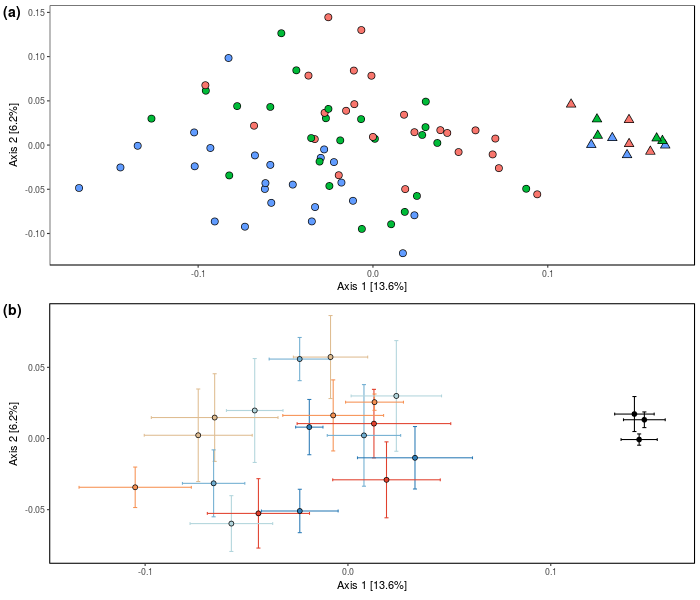

In [18]:
%%R -w 700 -h 600
require(cowplot)
p = ggplot(p.df,aes(x = Axis.1, y = Axis.2)) +
        geom_point(aes(shape=Planted, fill = TimePoint), size = 3) +
    scale_shape_manual(values = c(24, 21))+
    theme_pub() +
    xlab("Axis 1 [13.6%]") +
    ylab("Axis 2 [6.2%]") +
    theme(legend.position = "none")

 
tmp = p.df %>% group_by(Plant, R_Year, TimePoint) %>%
     summarize(mAxis.1 = mean(Axis.1),
                 seAxis.1 = sd(Axis.1)/sqrt(length(Axis.1)),
              mAxis.2 = mean(Axis.2), 
              seAxis.2 = sd(Axis.2)/sqrt(length(Axis.2)))


p1 =    ggplot(tmp, aes(x = mAxis.1, y = mAxis.2)) +
    theme_pub()+
    scale_fill_manual(values = c(GenotypeColors_sub6, "#000000")) +
    scale_color_manual(values = c(GenotypeColors_sub6, "#000000")) +
    geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2, color = Plant),     
                width = .002) +
    geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1, color = Plant),
                height = .002)+
    geom_point(aes(fill = Plant), color = "black", shape = 21, size = 2)+
    #geom_label(aes(color = Genotype), check_overlap = TRUE) + 
    xlab("Axis 1 [13.6%]") +
    ylab("Axis 2 [6.2%]") +
    theme(legend.position = "none") 
    #guides(fill = guide_legend(title = "Year"))
  
p1


LeftCol = plot_grid(p,p1, ncol = 1, align = "v", labels = c("(a)", "(b)"), hjust = .03)
LeftCol

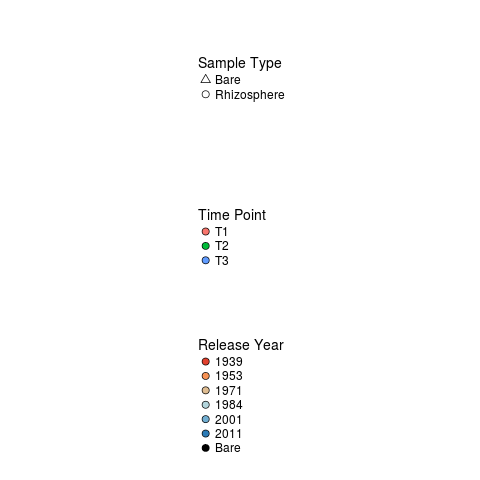

In [19]:
%%R
# collect legends
#Sample type shapes
pt = ggplot(p.df,aes(x = Axis.1, y = Axis.2)) +
        geom_point(aes(shape=Planted), size = 3) +
    scale_shape_manual(values = c(24, 21))+
    guides(shape = guide_legend(title = "Sample Type"))+
    theme(legend.position = "right")
    
TypeLegend = g_legend(pt)
pt


pt = ggplot(p.df,aes(x = Axis.1, y = Axis.2)) +
        geom_point(aes(fill = TimePoint), shape = 21, size = 3) +
    #scale_shape_manual(values = c(24, 21))+
     guides(fill = guide_legend(title = "Time Point"))+
    theme(legend.position = "right")
TimeLegend = g_legend(pt)
pt

pt = ggplot(tmp, aes(x = mAxis.1, y = mAxis.2)) +
        geom_point(aes(fill = Plant), shape = 21, size = 3) +
    scale_fill_manual(values = c(GenotypeColors_sub6, "#000000")) +
     guides(fill = guide_legend(title = "Release Year"))+
    theme(legend.position = "right")

    YearLegend = g_legend(pt)
pt

LG = plot_grid(TypeLegend, TimeLegend, YearLegend, ncol =1, align = "v")
LG

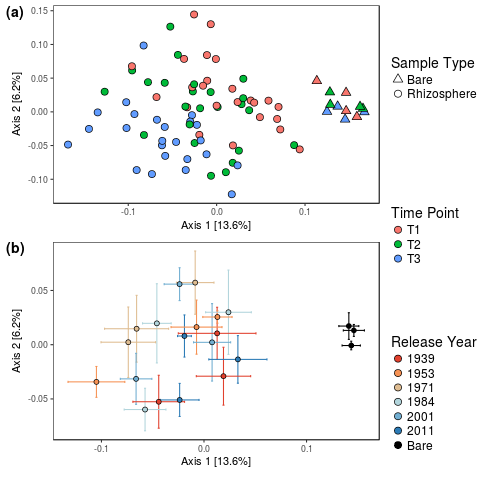

In [20]:
%%R
plot_grid(LeftCol, LG, rel_widths = c(2,.5))

In [46]:
%%R
svg(filename= '/home/bryan/ERA/data/figures/ms_versions/CoreOrdination_diss.svg', height = 6.5, width = 6.5)
grid.arrange(LeftCol, LG, ncol = 2, widths = c(2,.5))
dev.off()

png 
  2 


In [45]:
%%R
svg(filename= '/home/bryan/ERA/data/figures/ms_versions/CoreOrdination_ms.svg', height = 6.5, width = 7.08)
grid.arrange(LeftCol, LG, ncol = 2, widths = c(2,.5))
dev.off()

png 
  2 


## adonis: genotype effect in time 

In [22]:
%%R
rhiz.core = subset_samples(physeq, Plant %in% c("1939", "1953", "1971", "1984", "2001", "2011") & 
                             TimePoint != "T0" & Fert == "85")
rhiz.core

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 48 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [23]:
%%R

# create unifrac distance matrix
registerDoParallel(cores=28)


core.bray.dist = distance(rhiz.core, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [24]:
%%R
set.seed(101)

df = as(sample_data(rhiz.core), "data.frame")
d = core.bray.dist
df$Fert = as.factor(df$Fert)
Fulladonis = adonis(formula = d ~ Rep + TimePoint + Genotype  + Rep:TimePoint + Genotype:TimePoint , df, 
                    permutations = 999)
Fulladonis


Call:
adonis(formula = d ~ Rep + TimePoint + Genotype + Rep:TimePoint +      Genotype:TimePoint, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                   Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Rep                 3   0.22876 0.076254 1.89826 0.07246  0.001 ***
TimePoint           2   0.23288 0.116440 2.89864 0.07376  0.001 ***
Genotype            5   0.24769 0.049538 1.23320 0.07845  0.004 ** 
Rep:TimePoint       6   0.25658 0.042763 1.06453 0.08127  0.161    
TimePoint:Genotype 10   0.38366 0.038366 0.95508 0.12152  0.778    
Residuals          45   1.80767 0.040170         0.57255           
Total              71   3.15724                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# All rhizosphere samples for panel figures

In [25]:
%%R
phy.rhiz = subset_samples(physeq, Genotype != "Bare")
phy.rhiz

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 48 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


## Calculate Bray-Curtis dissimilarity between samples

In [26]:
%%R
registerDoParallel(cores=28)
bray.dist = distance(phy.rhiz, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [27]:
# %%R
# # order genotype by year
#  sample_data(phy.rhiz)$Genotype = reorder(sample_data(phy.rhiz)$Genotype, sample_data(phy.rhiz)$R_Year) 
# phy.rhiz %>% 
#     sample_data() %>%
#     .$Plant %>%
#     levels()

## PCoA with Bray-Curtis 

In [28]:
%%R
pcoa = ordinate(phy.rhiz, 
                method = "PCoA", 
                distance =bray.dist)

p.df = plot_ordination(phy.rhiz, pcoa, justDF = TRUE)


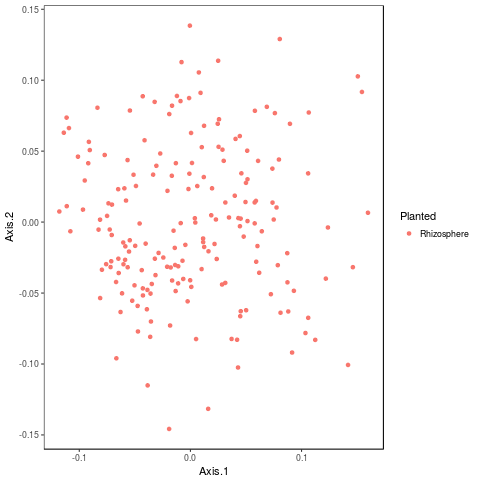

In [29]:
%%R

p = ggplot(p.df,aes(x = Axis.1, y = Axis.2)) +
        geom_point(aes(color=Planted)) +
    theme_pub()
        
p

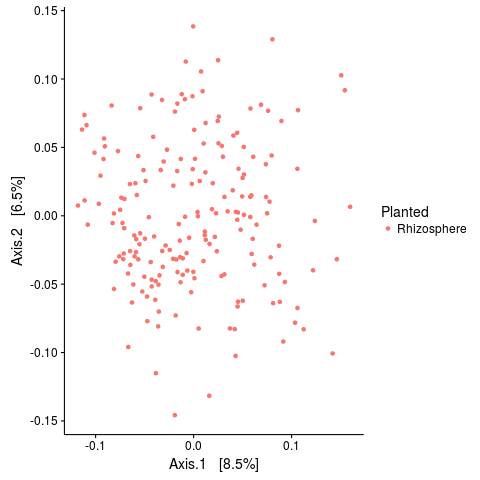

In [30]:
%%R
plot_ordination(physeq, pcoa, color = "Planted")


* Axis.1 [8.5%], Axis.2[6.5%]

### lsmeans from T1 for fertility and genotype 

In [31]:
%%R
sub = p.df %>% filter(TimePoint == "T1") %>%
    mutate(R_Year.c = R_Year - 1935,
           R_Year.f = factor(R_Year))
m1= lmer(Axis.1~R_Year.f + Fert + (1|Rep) + (1|Pos) + (1|Pos:Fert)  + (1|Rep:Row:Pos) ,  data = sub, na.action = na.exclude)
  print("Axis1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2= lmer(Axis.2~R_Year.f + Fert + (1|Rep) + (1|Pos) + (1|Pos:Fert)   + (1|Rep:Row:Pos) ,  data = sub, na.action = na.exclude)
  print("Axis2")
  anova(m2, ddf = "Kenward-Roger") %>% print


[1] "Axis1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
            Sum Sq    Mean Sq NumDF   DenDF F.value Pr(>F)
R_Year.f 0.0065788 0.00131576     5 12.7461 1.06392 0.4242
Fert     0.0011831 0.00059156     2  5.3897 0.47833 0.6438
[1] "Axis2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
            Sum Sq    Mean Sq NumDF   DenDF F.value Pr(>F)
R_Year.f 0.0041240 0.00082479     5 12.7471 0.46096 0.7983
Fert     0.0003363 0.00016813     2  5.3897 0.09397 0.9118


In [32]:
%%R
#Generate lsmeans for fert lsm Axes at T1 

Axis1.lsm.df = lsmeans(m1, pairwise~Fert) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(Fert,lsmean,SE, lower.CL, upper.CL)

colnames(Axis1.lsm.df)[2:5] = paste("Axis1", colnames(Axis1.lsm.df)[2:5], sep = ".")

Axis2.lsm.df = lsmeans(m2, pairwise~Fert) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(Fert,lsmean, SE, lower.CL, upper.CL)

colnames(Axis2.lsm.df)[2:5] = paste("Axis2", colnames(Axis2.lsm.df)[2:5], sep = ".")

T1.fert.lsm.df = full_join(Axis1.lsm.df, Axis2.lsm.df, by = "Fert") %>%
    mutate(TimePoint = "T1")
T1.fert.lsm.df

#Generate lsmeans for genotype lsm Axes at T1 

Axis1.lsm.df = lsmeans(m1, pairwise~R_Year.f) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(R_Year.f,lsmean,SE, lower.CL, upper.CL)

colnames(Axis1.lsm.df)[2:5] = paste("Axis1", colnames(Axis1.lsm.df)[2:5], sep = ".")

Axis2.lsm.df = lsmeans(m2, pairwise~R_Year.f) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(R_Year.f,lsmean, SE, lower.CL, upper.CL)

colnames(Axis2.lsm.df)[2:5] = paste("Axis2", colnames(Axis2.lsm.df)[2:5], sep = ".")

T1.R_Year.lsm.df = full_join(Axis1.lsm.df, Axis2.lsm.df, by = "R_Year.f") %>%
    mutate(TimePoint = "T1")
T1.R_Year.lsm.df

  R_Year.f Axis1.lsmean   Axis1.SE Axis1.lower.CL Axis1.upper.CL Axis2.lsmean
1     1939  -0.05386571 0.01233232    -0.08021072   -0.027520694  -0.01342538
2     1953  -0.05924071 0.01233232    -0.08558572   -0.032895698  -0.02765131
3     1971  -0.03305063 0.01233232    -0.05939564   -0.006705619  -0.03393778
4     1984  -0.06314815 0.01233232    -0.08949316   -0.036803134  -0.01121320
5     2001  -0.04379584 0.01233232    -0.07014085   -0.017450830  -0.02393266
6     2011  -0.05461851 0.01233232    -0.08096352   -0.028273501  -0.01516114
    Axis2.SE Axis2.lower.CL Axis2.upper.CL TimePoint
1 0.01566295    -0.04758041   0.0207296461        T1
2 0.01566295    -0.06180634   0.0065037181        T1
3 0.01566295    -0.06809281   0.0002172469        T1
4 0.01566295    -0.04536822   0.0229418319        T1
5 0.01566295    -0.05808769   0.0102223647        T1
6 0.01566295    -0.04931617   0.0189938859        T1


### R_Year at T2
* test model effects

In [48]:
%%R
sub = p.df %>% filter(TimePoint == "T2") %>%
    mutate(R_Year.c = R_Year - 1935)
m1= lmer(Axis.1~poly(R_Year.c, 2) + (1|Rep) + (1|Genotype) ,  data = sub, na.action = na.exclude)
  print("Axis1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2= lmer(Axis.2~poly(R_Year.c, 2)  + (1|Rep) + (1|Genotype) ,  data = sub, na.action = na.exclude)
  print("Axis2")
  anova(m2, ddf = "Kenward-Roger") %>% print


[1] "Axis1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                    Sum Sq   Mean Sq NumDF DenDF F.value  Pr(>F)  
poly(R_Year.c, 2) 0.010349 0.0051747     2     9  3.2382 0.08721 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "Axis2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                    Sum Sq   Mean Sq NumDF DenDF F.value Pr(>F)
poly(R_Year.c, 2) 0.011991 0.0059955     2     9  2.7293 0.1184


* Run with year as factor to get lsmeans

In [49]:
%%R
sub = p.df %>% filter(TimePoint == "T2") %>%
    mutate(R_Year.f = factor(R_Year))
m1= lmer(Axis.1~R_Year.f + (1|Rep) ,  data = sub, na.action = na.exclude)
  print("Axis1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2= lmer(Axis.2~R_Year.f  + (1|Rep)  ,  data = sub, na.action = na.exclude)
  print("Axis2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Axis1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
          Sum Sq   Mean Sq NumDF DenDF F.value  Pr(>F)  
R_Year.f 0.04487 0.0040791    11    33  2.5526 0.01847 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "Axis2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
           Sum Sq   Mean Sq NumDF DenDF F.value Pr(>F)
R_Year.f 0.026164 0.0023786    11    33  1.0051  0.463


In [50]:
%%R
#Generate lsmeans for Axes at T1 

Axis1.lsm.df = lsmeans(m1, pairwise~R_Year.f) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(R_Year.f,lsmean,SE, lower.CL, upper.CL)%>%
        mutate(Axis = "Axis1")



Axis2.lsm.df = lsmeans(m2, pairwise~R_Year.f) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(R_Year.f,lsmean,SE, lower.CL, upper.CL) %>%
        mutate(Axis = "Axis2")

#use bind rows for plotting axes seperately and easy faceting by axis
T2.RYear.lsm.df.long = bind_rows(Axis1.lsm.df, Axis2.lsm.df)  %>%
         mutate(TimePoint = "T2", 
          R_Year = as.numeric(as.character(R_Year.f)))

#rename columns and join by rows for easy plotting of both axes in ordination
colnames(Axis1.lsm.df)[2:5] = paste("Axis1", colnames(Axis1.lsm.df)[2:5], sep = ".")
colnames(Axis2.lsm.df)[2:5] = paste("Axis2", colnames(Axis2.lsm.df)[2:5], sep = ".")

T2.RYear.lsm.df = full_join(Axis1.lsm.df[1:5], Axis2.lsm.df[1:5], by = "R_Year.f") 


T2.RYear.lsm.df

   R_Year.f Axis1.lsmean   Axis1.SE Axis1.lower.CL Axis1.upper.CL Axis2.lsmean
1      1936 -0.032673238 0.02263265   -0.079438720    0.014092244  0.032891141
2      1939 -0.032693334 0.02263265   -0.079458816    0.014072148  0.028280853
3      1942  0.042198732 0.02263265   -0.004566750    0.088964214  0.015704908
4      1953 -0.014046207 0.02263265   -0.060811689    0.032719276 -0.017816748
5      1961  0.045412899 0.02263265   -0.001352583    0.092178381  0.016840781
6      1971  0.033562040 0.02263265   -0.013203442    0.080327522 -0.018513516
7      1975  0.029839964 0.02263265   -0.016925518    0.076605446 -0.046051988
8      1984  0.022277759 0.02263265   -0.024487724    0.069043241 -0.028887900
9      1991  0.009426982 0.02263265   -0.037338500    0.056192464  0.014117490
10     2001 -0.026318516 0.02263265   -0.073083998    0.020446966  0.001609444
11     2003 -0.042752298 0.02263265   -0.089517781    0.004013184  0.009771070
12     2011 -0.002089749 0.02263265   -0.048855231  

### Generate lsmeans for fertility and genotype at T3

In [43]:
%%R
sub = p.df %>% filter(TimePoint == "T3") %>%
    mutate(R_Year.f = factor(R_Year))
m1= lmer(Axis.1~R_Year.f + Fert + (1|Rep) + (1|Pos) + (1|Pos:Fert)  + (1|Rep:Row:Pos) ,  data = sub, na.action = na.exclude)
  print("Axis1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2= lmer(Axis.2~R_Year.f + Fert + (1|Rep) + (1|Pos) + (1|Pos:Fert)  + (1|Rep:Row:Pos) ,  data = sub, na.action = na.exclude)
  print("Axis2")
  anova(m2, ddf = "Kenward-Roger") %>% print


[1] "Axis1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
            Sum Sq   Mean Sq NumDF   DenDF F.value  Pr(>F)  
R_Year.f 0.0031519 0.0006304     5 12.8677  0.4498 0.80610  
Fert     0.0273925 0.0136963     2  5.3897  9.7719 0.01612 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "Axis2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
            Sum Sq   Mean Sq NumDF   DenDF F.value Pr(>F)
R_Year.f 0.0167076 0.0033415     5 12.7184  1.8152 0.1804
Fert     0.0003722 0.0001861     2  5.3897  0.1011 0.9055


In [44]:
%%R
#Generate lsmeans for fert lsm Axes at T3 

Axis1.lsm.df = lsmeans(m1, pairwise~Fert) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(Fert,lsmean,SE, lower.CL, upper.CL)

colnames(Axis1.lsm.df)[2:5] = paste("Axis1", colnames(Axis1.lsm.df)[2:5], sep = ".")

Axis2.lsm.df = lsmeans(m2, pairwise~Fert) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(Fert,lsmean, SE, lower.CL, upper.CL)

colnames(Axis2.lsm.df)[2:5] = paste("Axis2", colnames(Axis2.lsm.df)[2:5], sep = ".")

T3.fert.lsm.df = full_join(Axis1.lsm.df, Axis2.lsm.df, by = "Fert") %>%
    mutate(TimePoint = "T3")
T3.fert.lsm.df

#Generate lsmeans for genotype lsm Axes at T3 

Axis1.lsm.df = lsmeans(m1, pairwise~R_Year.f) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(R_Year.f,lsmean,SE, lower.CL, upper.CL)

colnames(Axis1.lsm.df)[2:5] = paste("Axis1", colnames(Axis1.lsm.df)[2:5], sep = ".")

Axis2.lsm.df = lsmeans(m2, pairwise~R_Year.f) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(R_Year.f,lsmean, SE, lower.CL, upper.CL)

colnames(Axis2.lsm.df)[2:5] = paste("Axis2", colnames(Axis2.lsm.df)[2:5], sep = ".")

T3.RYear.lsm.df = full_join(Axis1.lsm.df, Axis2.lsm.df, by = "R_Year.f") %>%
    mutate(TimePoint = "T3")
T3.RYear.lsm.df

  R_Year.f Axis1.lsmean   Axis1.SE Axis1.lower.CL Axis1.upper.CL Axis2.lsmean
1     1939   0.04154605 0.01413509    0.011689594     0.07140252   0.02411740
2     1953   0.05899544 0.01413509    0.029138980     0.08885190  -0.01114353
3     1971   0.05938330 0.01413509    0.029526834     0.08923976   0.01172640
4     1984   0.05700726 0.01413509    0.027150799     0.08686372   0.05656697
5     2001   0.04128848 0.01413509    0.011432015     0.07114494   0.02093533
6     2011   0.03878401 0.01413509    0.008927548     0.06864047   0.02541702
    Axis2.SE Axis2.lower.CL Axis2.upper.CL TimePoint
1 0.02022777    -0.02100357     0.06923837        T3
2 0.02022777    -0.05626450     0.03397744        T3
3 0.02022777    -0.03339457     0.05684737        T3
4 0.02022777     0.01144600     0.10168794        T3
5 0.02022777    -0.02418564     0.06605631        T3
6 0.02022777    -0.01970395     0.07053799        T3


In [45]:
%%R
Fert.lsm = bind_rows(T1.fert.lsm.df, T3.fert.lsm.df)

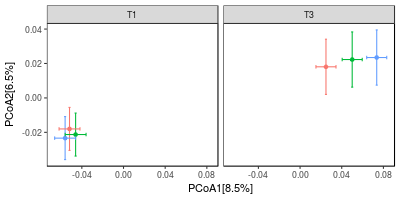

In [46]:
%%R -w 400 -h 200
pF = ggplot(Fert.lsm, aes(x = Axis1.lsmean, y = Axis2.lsmean, color = Fert)) +
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = Fert),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = Fert),
                height = .002) +
    theme(legend.position = "none")+
    xlab("PCoA1[8.5%]")+
    ylab("PCoA2[6.5%]")+
   facet_wrap(~TimePoint)

pF

* Get genotype coefficients by using R_Year as a factor

## Plot and arrange ordination figure

In [51]:
%%R
T2.RYear.lsm.df %>% head

  R_Year.f Axis1.lsmean   Axis1.SE Axis1.lower.CL Axis1.upper.CL Axis2.lsmean
1     1936  -0.03267324 0.02263265   -0.079438720     0.01409224   0.03289114
2     1939  -0.03269333 0.02263265   -0.079458816     0.01407215   0.02828085
3     1942   0.04219873 0.02263265   -0.004566750     0.08896421   0.01570491
4     1953  -0.01404621 0.02263265   -0.060811689     0.03271928  -0.01781675
5     1961   0.04541290 0.02263265   -0.001352583     0.09217838   0.01684078
6     1971   0.03356204 0.02263265   -0.013203442     0.08032752  -0.01851352
    Axis2.SE Axis2.lower.CL Axis2.upper.CL
1 0.02864766    -0.02698865     0.09277093
2 0.02864766    -0.03159894     0.08816065
3 0.02864766    -0.04417489     0.07558470
4 0.02864766    -0.07769654     0.04206305
5 0.02864766    -0.04303901     0.07672057
6 0.02864766    -0.07839331     0.04136628


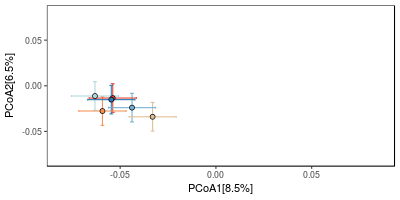

In [52]:
%%R -w 400 -h 200
pG1 = ggplot(T1.R_Year.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean)) +
    scale_fill_manual(values = c(GenotypeColors_sub6)) +
    scale_color_manual(values = c(GenotypeColors_sub6)) +
    theme_pub()+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = R_Year.f),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = R_Year.f),
                height = .002) +
     geom_point(aes(fill = R_Year.f), color = "black", shape = 21, size = 2)+
    theme(legend.position = "none")+
    xlab("PCoA1[8.5%]")+
    ylab("PCoA2[6.5%]")+
      xlim(c(-0.08, 0.085))+
    ylim(c(-0.08,0.08))

pG1

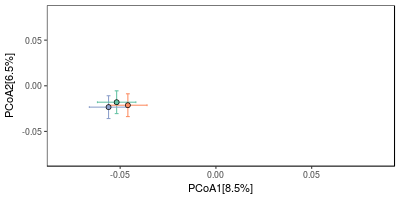

In [53]:
%%R -w 400 -h 200
pF1 = ggplot(T1.fert.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean)) +
        scale_color_manual(values = FertColors)+
    scale_fill_manual(values = FertColors)+
    theme_pub()+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = Fert),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = Fert),
                height = .002) +
    geom_point(aes(fill = Fert), shape = 21, size = 2, color = "black")+
    theme(legend.position = "none")+
    xlab("PCoA1[8.5%]")+
    ylab("PCoA2[6.5%]")+
      xlim(c(-0.08, 0.085))+
    ylim(c(-0.08,0.08))

pF1

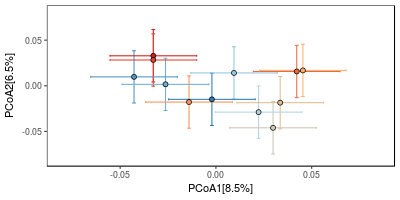

In [54]:
%%R -w 400 -h 200
pG2 = ggplot(T2.RYear.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean)) +
   
    scale_fill_manual(values = c(GenotypeColors)) +
    scale_color_manual(values = c(GenotypeColors)) +
    theme_pub()+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = R_Year.f),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = R_Year.f),
                height = .002) +
     geom_point(aes(fill = R_Year.f), color = "black", shape = 21, size = 2)+
    theme(legend.position = "none")+
    xlab("PCoA1[8.5%]")+
    ylab("PCoA2[6.5%]")+
     xlim(c(-0.08, 0.085))+
    ylim(c(-0.08,0.08))

pG2

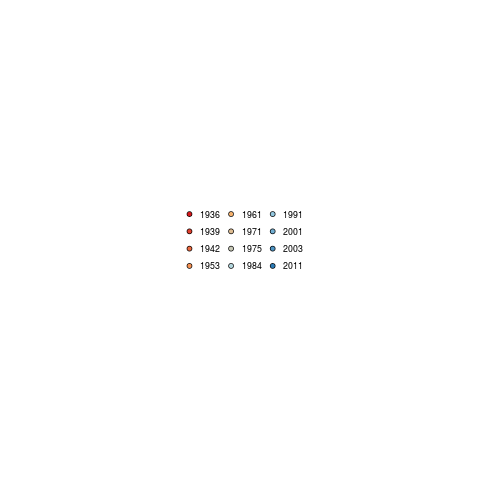

In [55]:
%%R 
# Just to gather legend
P = ggplot(T2.RYear.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean)) +
    
    scale_fill_manual(values = c(GenotypeColors)) +
   # scale_color_manual(values = c(GenotypeColors)) +
    theme_pub()+
    #geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = R_Year.f),      
               # width = .002) +
    #geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = R_Year.f),
               # height = .002) +
    geom_point(aes(fill = R_Year.f), color = "black", shape = 21, size = 2)+#pch = 21, color = "black")+
    theme(legend.position = "bottom")+
    guides(fill = guide_legend(title = NULL, title.position = NULL, ncol = 3))+
    xlab("PCoA1[8.5%]")+
    ylab("PCoA2[6.5%]")+
     xlim(c(-0.08, 0.085))+
    ylim(c(-0.08,0.08))



ERAlegend <- g_legend(P)
                        
grid.arrange(ERAlegend)
                        


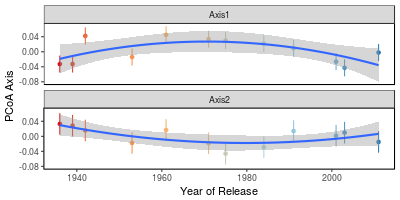

In [56]:
%%R -w 400 -h 200
pY2 = ggplot(T2.RYear.lsm.df.long, aes(x = R_Year, y = lsmean)) +
    geom_point(aes(color = R_Year.f))+
    theme_pub()+
    geom_errorbar(aes(ymin = lsmean - SE , ymax = lsmean + SE , color = R_Year.f),      
                width = .002) +
    scale_color_manual(values = c(GenotypeColors))+
    #xlim(c(-0.06, 0.09)) +
 
    theme(legend.position = "none")+
    xlab("Year of Release")+
    ylab("PCoA Axis")+
    stat_smooth(method = "lm", formula = y ~poly(x,2)) +
   facet_wrap(~Axis, ncol = 1) 



pY2

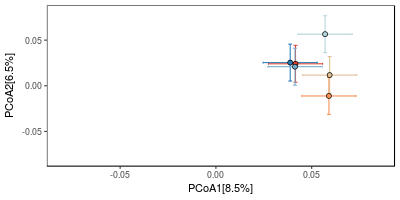

In [57]:
%%R -w 400 -h 200
pG3 = ggplot(T3.RYear.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean)) +
    scale_fill_manual(values = c(GenotypeColors_sub6)) +
    scale_color_manual(values = c(GenotypeColors_sub6)) +
    theme_pub()+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = R_Year.f),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = R_Year.f),
                height = .002) +
    geom_point(aes(fill = R_Year.f), color = "black", shape = 21, size = 2)+#pch = 21, color = "black")+
    theme(legend.position = "none")+
    xlab("PCoA1[8.5%]")+
    ylab("PCoA2[6.5%]")+
     xlim(c(-0.08, 0.085))+
    ylim(c(-0.08,0.08))

pG3

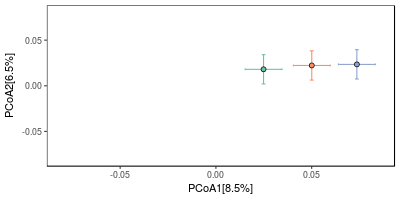

In [58]:
%%R -w 400 -h 200
pF3 = ggplot(T3.fert.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean)) +
    scale_color_manual(values = FertColors)+
    scale_fill_manual(values = FertColors)+
    theme_pub()+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = Fert),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = Fert),
                height = .002) +
    geom_point(aes(fill = Fert), shape = 21, size = 2, color = "black")+
    theme(legend.position = "none")+
    xlab("PCoA1[8.5%]")+
    ylab("PCoA2[6.5%]")+
      xlim(c(-0.08, 0.085))+
    ylim(c(-0.08,0.08))
    
pF3

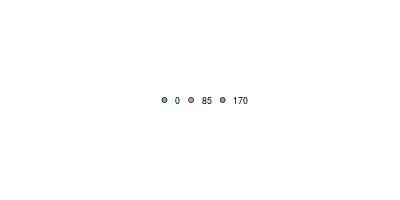

In [59]:
%%R -w 400 -h 200
# just to gather fert legend
P = ggplot(T3.fert.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean)) +
    #scale_color_manual(values = FertColors)+
    scale_fill_manual(values = FertColors)+
    theme_pub()+
#     geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = Fert),      
#                 width = .002) +
#     geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = Fert),
#                 height = .002) +
    geom_point(aes(fill = Fert), shape = 21, size = 2, color = "black")+
    theme(legend.position = "bottom")+
    guides(fill = guide_legend(title = NULL, title.position = NULL, ncol = 3))+
    xlab("PCoA1[8.5%]")+
    ylab("PCoA2[6.5%]")+
      xlim(c(-0.08, 0.085))+
    ylim(c(-0.08,0.08))
    
    Fertlegend = g_legend(P)
    
grid.arrange(Fertlegend)

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name              grob
1 1 (1-1,1-1) arrange gtable[guide-box]
2 2 (2-2,1-1) arrange gtable[guide-box]


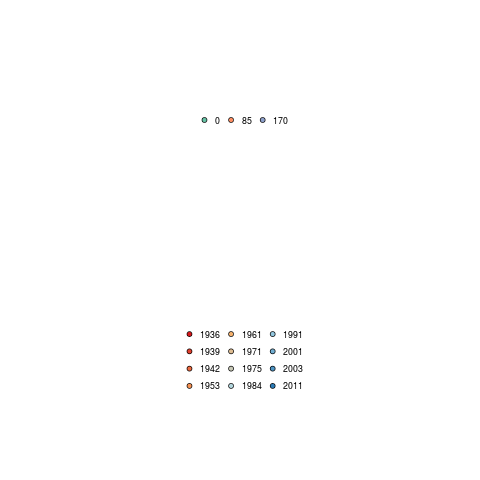

In [60]:
%%R
L = grid.arrange(Fertlegend, ERAlegend, ncol = 1)
L %>% print

### Arrange plots

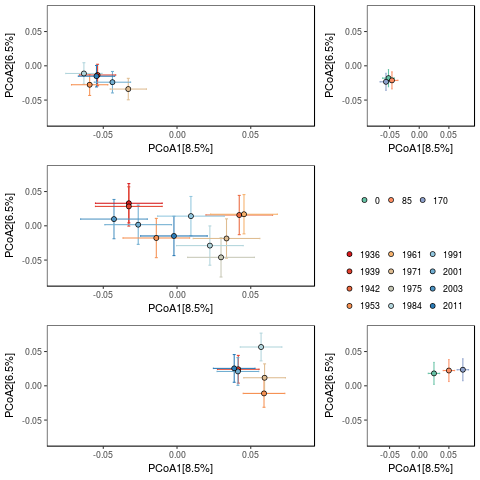

In [61]:
%%R
#layout = rbind(c(1,1,1,2,2,2), c(3,3,3,3,4,4), c(5,5,5,6,6,6))
layout = rbind(c(1,1,2), c(3,3,4), c(5,5,6))
grid.arrange(pG1, pF1, pG2, L, pG3, pF3, layout_matrix = layout)

In [80]:
%%R
svg(filename = '/home/bryan/ERA/data/figures/ms_versions/Figure3_diss.svg', width = 6.5, height = 6.5)
grid.arrange(pG1, pF1, pG2, L, pG3, pF3, layout_matrix = layout)
dev.off()



png 
  2 


In [81]:
%%R
svg(filename = '/home/bryan/ERA/data/figures/ms_versions/Figure3_ms.svg', width = 7.086, height = 6.5)
grid.arrange(pG1, pF1, pG2, L, pG3, pF3, layout_matrix = layout)
dev.off()

png 
  2 


In [62]:
%%R
sessionInfo()

R version 3.3.2 (2016-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.3 LTS

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] cowplot_0.7.0      RColorBrewer_1.1-2 lsmeans_2.25-5     estimability_1.2  
 [5] lmerTest_2.0-33    lme4_1.1-13        Matrix_1.2-10      MuMIn_1.15.6      
 [9] phyloseq_1.19.1    vegan_2.4-3        lattice_0.20-35    permute_0.9-4     
[13] tidyr_0.6.0        dplyr_0.5.0        gridExtra_2.2.1    doParallel_1.0.10 
[17] iterators_1.0.8    foreach_1.4.3      ggplot2_2.2.1     
